# Part 1: NYC Taxi Trip Duration Prediction

## Introduction

In this notebook, we will build and evaluate regression models to predict the duration of NYC yellow taxi trips using real-world trip data. The workflow covers:

- Downloading and preparing the data
- Feature engineering (including trip duration calculation and categorical encoding)
- Training and evaluating linear and ridge regression models
- Tracking experiments and model parameters with MLflow

By the end, you will understand how to structure a machine learning workflow for tabular data, compare model performance, and use MLflow for experiment tracking.

**First, you must launch the MLflow tracking server** by running the following command in your terminal:

```bash
mlflow server --backend-store-uri sqlite:///mlflow.db
```

The MLflow UI will be available at [http://localhost:5000](http://localhost:5000) by default after you start the server.

If you have previous MLflow servers running on port 5000, you should stop them first.
You can find and kill any process using port 5000 with:

```bash
lsof -i :5000
kill -9 1234
```

In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from mlflow.tracking import MlflowClient
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

os.makedirs('models', exist_ok=True)
warnings.filterwarnings('ignore', category=UserWarning, module='mlflow')
warnings.filterwarnings('ignore')

## 1. Experiment Tracking with MLflow

In [2]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

2025/06/29 11:11:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/06/29 11:11:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/06/29 11:11:43 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/nyc-taxi-mlflow/mlruns/1', creation_time=1751195503856, experiment_id='1', last_update_time=1751195503856, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## 2. Data Download



In [3]:
# Define variables for train and validation data paths to avoid repetition and improve maintainability
TRAIN_PATH = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"
VALID_PATH = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet"
df = pd.read_parquet(TRAIN_PATH)

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
len(df.columns)

19

## 3. Feature Engineering: Compute Trip Duration

In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [7]:
df.duration.mean()

np.float64(15.612950619257845)

In [8]:
df.duration.std()

np.float64(34.851053592212814)

## 4. Remove Outliers

In [9]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

97.78326020432945

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

## 5. Feature Engineering: One-Hot Encoding

In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
categorical = ['PU_DO']

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (2898906, 24016)


## 6. Model Training: Linear Regression

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Linear Regression Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Linear Regression Train RMSE: 5.297043492966795


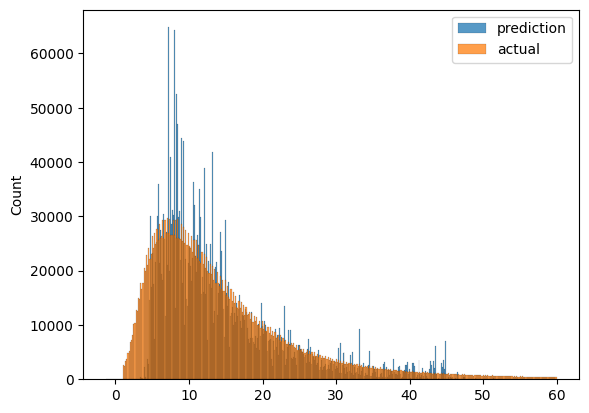

In [18]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

## 7. Model Evaluation

In [19]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical_ = ['PU_DO']
    
    return df, categorical_, numerical

In [20]:
df_val, categorical_, numerical = read_data(VALID_PATH)

In [21]:
val_dicts = df_val[categorical_ + numerical].to_dict(orient='records')

In [22]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

# Start an MLflow run to log parameters, metrics, and artifacts
with mlflow.start_run() as run:
    mlflow.set_tag('developer', 'xabier')
    mlflow.log_param('train-data-path', TRAIN_PATH)
    mlflow.log_param('valid-data-path', VALID_PATH)

    mlflow.set_tag('model', 'linear_regression')
    mlflow.set_tag('type', 'regression')
    
    y_pred = lr.predict(X_val)

    val_rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('val_rmse', val_rmse)
    print(f'Linear Regression Val RMSE: {val_rmse:.4f}')

    # Save preprocessor and model together for reproducibility
    model_path = 'models/lin_reg.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
    mlflow.log_artifact(model_path, 'models')

    # Log the sklearn model in a way that is compatible with the model registry
    input_example = X_val[:2] if hasattr(X_val, '__getitem__') else None
    mlflow.sklearn.log_model(lr, name='models', input_example=input_example)

Linear Regression Val RMSE: 5.5057


In [23]:
MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

# List all experiments and print their details for better visibility
experiments = client.search_experiments()
for exp in experiments:
    print(f"ID: {exp.experiment_id}, Name: {exp.name}, Artifact Location: {exp.artifact_location}, Lifecycle Stage: {exp.lifecycle_stage}")

ID: 1, Name: nyc-taxi-experiment, Artifact Location: /workspaces/mlops-zoomcamp/02-experiment-tracking/nyc-taxi-mlflow/mlruns/1, Lifecycle Stage: active
ID: 0, Name: Default, Artifact Location: mlflow-artifacts:/0, Lifecycle Stage: active


## 8. Model Training: Ridge Regression

#### Ridge Regression, a = 0.1

In [24]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'xabier')
    mlflow.log_param('train-data-path', TRAIN_PATH)
    mlflow.log_param('valid-data-path', VALID_PATH)
    
    mlflow.set_tag('model', 'ridge')
    mlflow.set_tag('type', 'regression')
    
    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)

    y_pred_ridge = ridge.predict(X_val)
    mlflow.log_metric('val_rmse', root_mean_squared_error(y_val, y_pred_ridge))
    print(f"Ridge Val RMSE: {root_mean_squared_error(y_val, y_pred_ridge):.3f}")

    # Save preprocessor and model together
    model_path = 'models/ridge_reg_01.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, ridge), f_out)
    mlflow.log_artifact(model_path, 'models')

    # Log the sklearn model for model registry
    input_example = X_val[:2] if hasattr(X_val, '__getitem__') else None
    mlflow.sklearn.log_model(ridge, name='models', input_example=input_example)

Ridge Val RMSE: 5.473


#### Ridge Regression, a = 0.01

In [25]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'xabier')
    mlflow.log_param('train-data-path', TRAIN_PATH)
    mlflow.log_param('valid-data-path', VALID_PATH)
    
    mlflow.set_tag('model', 'ridge')
    mlflow.set_tag('type', 'regression')
    
    alpha = 0.01
    mlflow.log_param('alpha', alpha)
    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)

    y_pred_ridge = ridge.predict(X_val)
    mlflow.log_metric('val_rmse', root_mean_squared_error(y_val, y_pred_ridge))
    print(f"Ridge Val RMSE: {root_mean_squared_error(y_val, y_pred_ridge):.3f}")

    # Save preprocessor and model together
    model_path = 'models/ridge_reg_001.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, ridge), f_out)
    mlflow.log_artifact(model_path, 'models')

    # Log the sklearn model for model registry
    input_example = X_val[:2] if hasattr(X_val, '__getitem__') else None
    mlflow.sklearn.log_model(ridge, name='models', input_example=input_example)

Ridge Val RMSE: 5.473


#### Lasso Regression, a = 0.05

In [26]:
from sklearn.linear_model import Lasso

with mlflow.start_run():
    mlflow.set_tag('developer', 'xabier')
    mlflow.log_param('train-data-path', TRAIN_PATH)
    mlflow.log_param('valid-data-path', VALID_PATH)
    
    mlflow.set_tag('model', 'lasso')
    mlflow.set_tag('type', 'regression')
    
    alpha = 0.05
    mlflow.log_param('alpha', alpha)
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_val)
    mlflow.log_metric('val_rmse', root_mean_squared_error(y_val, y_pred_lasso))
    print(f"Lasso Val RMSE: {root_mean_squared_error(y_val, y_pred_lasso):.3f}")

    # Save preprocessor and model together
    model_path = 'models/lasso_reg.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, lasso), f_out)
    mlflow.log_artifact(model_path, 'models')

    # Log the sklearn model for model registry
    input_example = X_val[:2] if hasattr(X_val, '__getitem__') else None
    mlflow.sklearn.log_model(lasso, name='models', input_example=input_example)

Lasso Val RMSE: 10.250
